# 🐕 DOGE Patterned Dataset & ROI Analysis
## Prediksi Pencapaian ROI dan Potensi Profit Maksimum pada Trading Spot DOGE menggunakan K-Means Clustering dan Patterned Dataset Model

---

**Kerangka Metodologi:** CRISP-DM (Cross-Industry Standard Process for Data Mining)

**Adaptasi dari Paper:** *"Prediction of ROI Achievements and Potential Maximum Profit on Spot Bitcoin Rupiah Trading Using K-means Clustering and Patterned Dataset Model"*

---

### Struktur Notebook:
- **00 – Setup & Imports**
- **01 – Business Understanding**
- **02 – Data Understanding**
- **03 – Data Preparation (Patterned Dataset)**
- **04 – Modeling (K-means + ROI)**
- **05 – Evaluation & Conclusion**
- **06 – Deployment**

---
# 00 – Setup & Library Imports
---

In [1]:
# Cek versi Python & suppress warnings
import sys, warnings
warnings.filterwarnings("ignore")
print(f"Python Version: {sys.version}")

Python Version: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]


In [2]:
# Import semua library yang dibutuhkan
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score,
    rand_score, adjusted_rand_score, fowlkes_mallows_score,
    homogeneity_score, v_measure_score
)

# HTTP & progress
import requests
from tqdm import tqdm

# Untuk pickle model
import pickle

print("✅ Semua library berhasil di-import!")

✅ Semua library berhasil di-import!


In [3]:
# Definisi path untuk output
BASE_DIR = "/media/krisnaepras/Shared/Project/kuliah/datmin/fp3"
RAW_DATA_PATH = os.path.join(BASE_DIR, "data/raw")
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, "data/processed")
FIGURES_PATH = os.path.join(BASE_DIR, "figures")
MODELS_PATH = os.path.join(BASE_DIR, "models")

# Pastikan folder sudah ada
for path in [RAW_DATA_PATH, PROCESSED_DATA_PATH, FIGURES_PATH, MODELS_PATH]:
    os.makedirs(path, exist_ok=True)
    
print(f"📁 Base Directory: {BASE_DIR}")
print(f"📁 Raw Data: {RAW_DATA_PATH}")
print(f"📁 Processed Data: {PROCESSED_DATA_PATH}")
print(f"📁 Figures: {FIGURES_PATH}")
print(f"📁 Models: {MODELS_PATH}")

📁 Base Directory: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3
📁 Raw Data: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/raw
📁 Processed Data: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/processed
📁 Figures: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures
📁 Models: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/models


---
# 01 – Business Understanding
---

## 1.1 Ringkasan Paper Asli

Paper *"Prediction of ROI Achievements and Potential Maximum Profit on Spot Bitcoin Rupiah Trading Using K-means Clustering and Patterned Dataset Model"* memperkenalkan metode analisis trading cryptocurrency menggunakan:

1. **Patterned Dataset Model**: Transformasi data OHLC menjadi fitur-fitur pola harga seperti Range (R), Top Range (TR), Lower Range (LR), Percent Top Range (PTR), dan Percent Low Range (PLR).

2. **K-means Clustering**: Membagi data ke dalam cluster berdasarkan pola harga untuk mengidentifikasi kondisi pasar (Crash vs Moon).

3. **Diamond Crash Detection**: Mengidentifikasi momen ketika harga mendekati titik terendah harian (low) sebagai sinyal potensial untuk pembelian.

4. **ROI Calculation**: Menghitung potensi profit dalam jangka harian (D) dan bulanan (M) setelah kondisi Diamond Crash terdeteksi.

---

## 1.2 Adaptasi ke DOGE

Proyek ini mengadaptasi metodologi di atas untuk aset **DOGE (Dogecoin)** dengan karakteristik:

- **Aset**: DOGE/USDT (spot trading only, bukan futures/leverage)
- **Periode Data**: ±2-3 tahun terakhir hingga hari ini (30 November 2025)
- **Quote Currency**: USDT (karena likuiditas lebih tinggi dibanding IDR)

---

## 1.3 Pertanyaan Riset

1. **Apakah M ROI (Monthly ROI) secara konsisten lebih besar daripada D ROI (Daily ROI) pada DOGE seperti temuan pada Bitcoin?**

2. **Bagaimana frekuensi munculnya kondisi Diamond Crash pada DOGE per bulan?**

3. **Apakah strategi "beli saat Diamond Crash" lebih menguntungkan dibandingkan strategi buy & hold?**

---

## 1.4 Definisi Kunci

| Istilah | Definisi |
|---------|----------|
| **R (Range)** | Selisih harga tertinggi dan terendah harian: `H - L` |
| **TR (Top Range)** | Jarak dari harga tertinggi ke harga penutupan: `H - C` |
| **LR (Lower Range)** | Jarak dari harga penutupan ke harga terendah: `C - L` |
| **PTR (Percent Top Range)** | Persentase TR terhadap R: `(TR/R) × 100` |
| **PLR (Percent Low Range)** | Persentase LR terhadap R: `(LR/R) × 100` |
| **Crash** | Kondisi di mana harga mendekati low harian (PTR tinggi, PLR rendah) |
| **Moon** | Kondisi di mana harga mendekati high harian (PLR tinggi, PTR rendah) |
| **Diamond Crash** | Crash yang paling ekstrem (PTR di top 10%) – sinyal beli potensial |
| **D ROI** | Return on Investment dalam 24 jam setelah Diamond Crash |
| **M ROI** | Return on Investment dalam 1 bulan setelah Diamond Crash |

---
# 02 – Data Understanding
---

## 2.1 Data Acquisition

Mengambil data historical OHLCV DOGE/USDT dari **Binance API** dengan resolusi **hourly (1 jam)** untuk periode 2+ tahun terakhir.

**Sumber Data:** Binance REST API (klines endpoint)
- Endpoint: `https://api.binance.com/api/v3/klines`
- Symbol: `DOGEUSDT`
- Interval: `1h` (hourly)
- Limit: 1000 candles per request

In [4]:
def fetch_binance_ohlcv(symbol: str, interval: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Mengambil data OHLCV dari Binance API.
    
    Parameters:
    -----------
    symbol : str
        Trading pair (e.g., 'DOGEUSDT')
    interval : str
        Candle interval (e.g., '1h', '1d')
    start_date : datetime
        Tanggal mulai
    end_date : datetime
        Tanggal akhir
        
    Returns:
    --------
    pd.DataFrame
        DataFrame dengan kolom: timestamp, open, high, low, close, volume
    """
    base_url = "https://api.binance.com/api/v3/klines"
    all_data = []
    
    # Convert to milliseconds
    start_ts = int(start_date.timestamp() * 1000)
    end_ts = int(end_date.timestamp() * 1000)
    
    current_start = start_ts
    
    print(f"📊 Fetching {symbol} data from {start_date.date()} to {end_date.date()}...")
    
    with tqdm(total=(end_ts - start_ts) // (1000 * 3600 * 1000) + 1, desc="Downloading") as pbar:
        while current_start < end_ts:
            params = {
                'symbol': symbol,
                'interval': interval,
                'startTime': current_start,
                'endTime': end_ts,
                'limit': 1000
            }
            
            try:
                response = requests.get(base_url, params=params, timeout=30)
                response.raise_for_status()
                data = response.json()
                
                if not data:
                    break
                    
                all_data.extend(data)
                
                # Update start time untuk request berikutnya
                current_start = data[-1][0] + 1
                
                # Update progress
                pbar.update(len(data))
                
            except requests.exceptions.RequestException as e:
                print(f"⚠️ Error fetching data: {e}")
                break
    
    if not all_data:
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    
    # Select dan convert kolom yang dibutuhkan
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Convert numeric columns
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)
    
    print(f"✅ Downloaded {len(df)} candles")
    
    return df

# Definisi periode data
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=2*365 + 180)  # ~2.5 tahun ke belakang

print(f"📅 Periode Data: {START_DATE.date()} sampai {END_DATE.date()}")

📅 Periode Data: 2023-06-04 sampai 2025-11-30


In [8]:
# Gunakan yfinance untuk mendapatkan data DOGE
import yfinance as yf

def fetch_doge_yfinance(start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Mengambil data OHLCV DOGE dari Yahoo Finance.
    
    Parameters:
    -----------
    start_date : datetime
        Tanggal mulai
    end_date : datetime
        Tanggal akhir
        
    Returns:
    --------
    pd.DataFrame
        DataFrame dengan kolom: timestamp, open, high, low, close, volume
    """
    print(f"📊 Fetching DOGE-USD data from {start_date.date()} to {end_date.date()}...")
    
    # Fetch data DOGE-USD dari Yahoo Finance (interval 1h atau 1d)
    ticker = yf.Ticker("DOGE-USD")
    
    # Untuk data historical yang panjang, kita pakai interval daily
    # Karena yfinance hourly hanya tersedia untuk 730 hari terakhir
    df = ticker.history(start=start_date, end=end_date, interval="1d")
    
    if df.empty:
        print("⚠️ No data returned from yfinance")
        return pd.DataFrame()
    
    # Reset index dan rename columns
    df = df.reset_index()
    df = df.rename(columns={
        'Date': 'timestamp',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    })
    
    # Select kolom yang dibutuhkan
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
    
    # Convert timestamp to datetime tanpa timezone
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)
    
    print(f"✅ Downloaded {len(df)} daily candles")
    return df

# Path untuk cache data
RAW_CSV_PATH = os.path.join(RAW_DATA_PATH, "doge_ohlc_daily.csv")

# Cek apakah cache valid sudah ada
if os.path.exists(RAW_CSV_PATH):
    try:
        df_raw = pd.read_csv(RAW_CSV_PATH, parse_dates=['timestamp'])
        if len(df_raw) > 0:
            print(f"📂 Loading cached data from {RAW_CSV_PATH}...")
            print(f"✅ Loaded {len(df_raw)} rows from cache")
        else:
            raise ValueError("Empty cache")
    except:
        os.remove(RAW_CSV_PATH)
        df_raw = None
else:
    df_raw = None

if df_raw is None:
    print("🌐 Fetching fresh data from Yahoo Finance...")
    df_raw = fetch_doge_yfinance(start_date=START_DATE, end_date=END_DATE)
    
    if len(df_raw) > 0:
        # Save to cache
        df_raw.to_csv(RAW_CSV_PATH, index=False)
        print(f"💾 Data saved to {RAW_CSV_PATH}")
    else:
        print("❌ Failed to fetch data!")

if len(df_raw) > 0:
    print(f"\n📊 Shape: {df_raw.shape}")
    print(f"📅 Date Range: {df_raw['timestamp'].min()} to {df_raw['timestamp'].max()}")

🌐 Fetching fresh data from Yahoo Finance...
📊 Fetching DOGE-USD data from 2023-06-04 to 2025-11-30...
✅ Downloaded 909 daily candles
💾 Data saved to /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/raw/doge_ohlc_daily.csv

📊 Shape: (909, 6)
📅 Date Range: 2023-06-04 00:00:00 to 2025-11-28 00:00:00


## 2.2 Exploratory Data Analysis (EDA)

Eksplorasi awal untuk memahami struktur dan karakteristik data DOGE/USD.

In [9]:
# Tampilkan informasi dasar dataset
print("="*60)
print("📋 INFORMASI DATASET DOGE/USD")
print("="*60)

print("\n🔍 Head (5 baris pertama):")
print(df_raw.head())

print("\n📊 Info:")
print(df_raw.info())

print("\n📈 Statistik Deskriptif:")
print(df_raw.describe())

📋 INFORMASI DATASET DOGE/USD

🔍 Head (5 baris pertama):
   timestamp      open      high       low     close     volume
0 2023-06-04  0.072672  0.073250  0.072466  0.072471  135558595
1 2023-06-05  0.072475  0.072632  0.064828  0.066573  506101788
2 2023-06-06  0.066568  0.071784  0.066112  0.070373  428926152
3 2023-06-07  0.070371  0.070371  0.066878  0.067300  278793457
4 2023-06-08  0.067302  0.068426  0.067154  0.067966  167825308

📊 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  909 non-null    datetime64[ns]
 1   open       909 non-null    float64       
 2   high       909 non-null    float64       
 3   low        909 non-null    float64       
 4   close      909 non-null    float64       
 5   volume     909 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 42.7 KB
N

## 2.3 Data Quality Check

Pengecekan kualitas data: missing values, duplicate timestamps, dan anomali.

In [10]:
# Cek Missing Values
print("="*60)
print("🔍 DATA QUALITY CHECK")
print("="*60)

print("\n1️⃣ Missing Values per Kolom:")
missing_values = df_raw.isnull().sum()
print(missing_values)
print(f"\nTotal Missing: {missing_values.sum()}")

# Cek Duplicate Timestamps
print("\n2️⃣ Duplicate Timestamps:")
duplicates = df_raw.duplicated(subset=['timestamp']).sum()
print(f"Jumlah timestamp duplikat: {duplicates}")

# Cek range OHLC yang valid (Low <= Close <= High, Low <= Open <= High)
print("\n3️⃣ Validasi OHLC:")
invalid_ohlc = (
    (df_raw['low'] > df_raw['close']) | 
    (df_raw['close'] > df_raw['high']) |
    (df_raw['low'] > df_raw['open']) |
    (df_raw['open'] > df_raw['high'])
).sum()
print(f"Jumlah baris dengan OHLC tidak valid: {invalid_ohlc}")

# Cek nilai negatif atau nol
print("\n4️⃣ Nilai Negatif atau Nol:")
for col in ['open', 'high', 'low', 'close', 'volume']:
    neg_zero = (df_raw[col] <= 0).sum()
    print(f"   {col}: {neg_zero} nilai <= 0")

print("\n✅ Data Quality Check selesai!")

🔍 DATA QUALITY CHECK

1️⃣ Missing Values per Kolom:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Total Missing: 0

2️⃣ Duplicate Timestamps:
Jumlah timestamp duplikat: 0

3️⃣ Validasi OHLC:
Jumlah baris dengan OHLC tidak valid: 0

4️⃣ Nilai Negatif atau Nol:
   open: 0 nilai <= 0
   high: 0 nilai <= 0
   low: 0 nilai <= 0
   close: 0 nilai <= 0
   volume: 0 nilai <= 0

✅ Data Quality Check selesai!


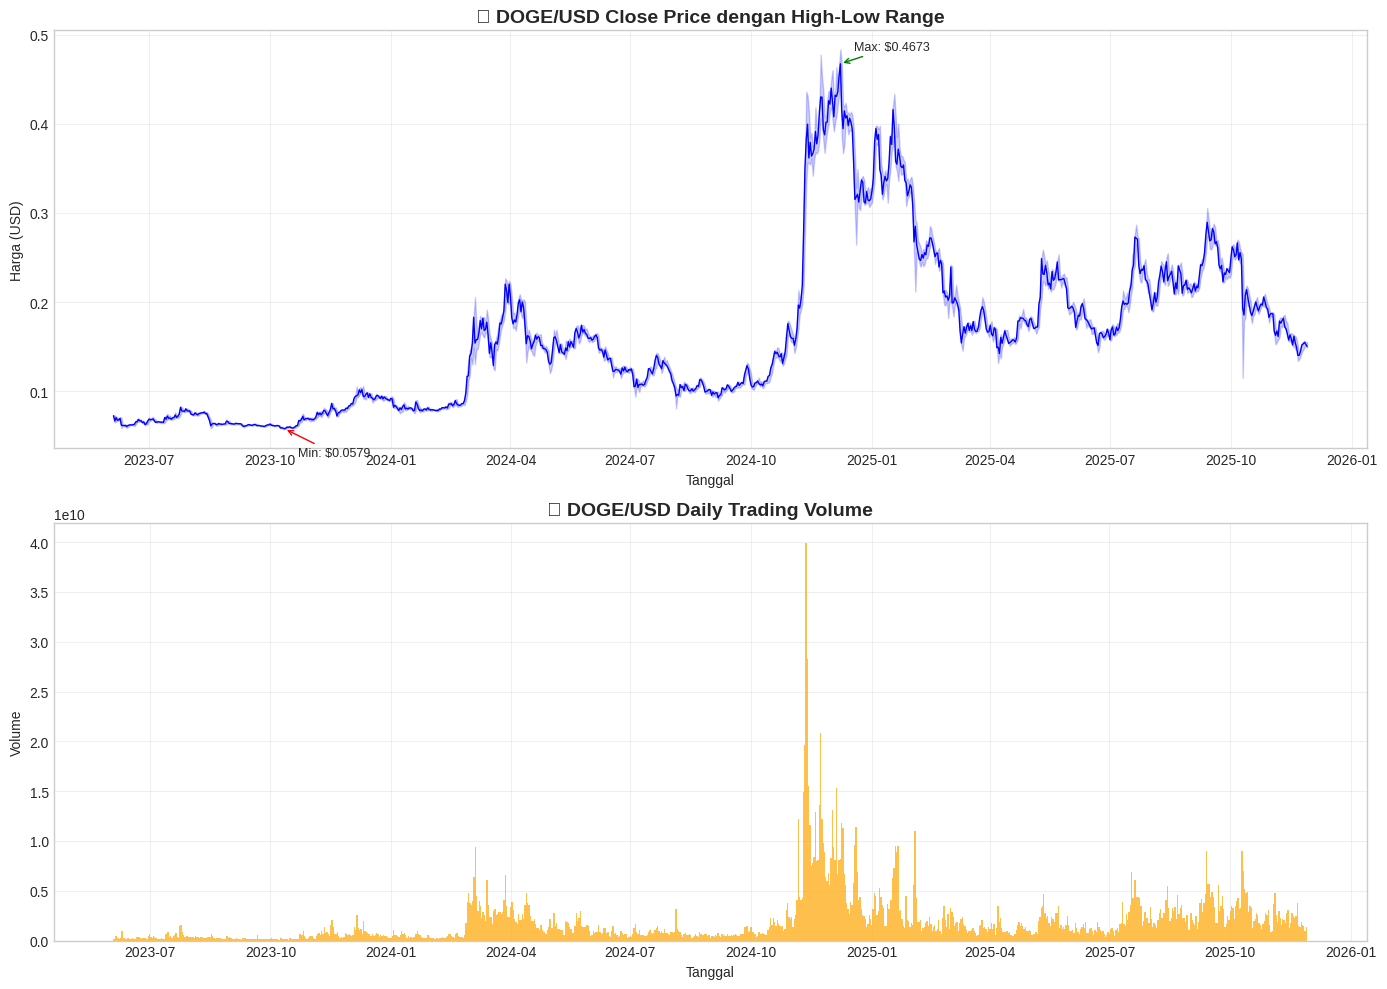


💾 Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/doge_price_volume_timeseries.png


In [11]:
# Visualisasi Time Series Harga DOGE
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Close Price
ax1 = axes[0]
ax1.plot(df_raw['timestamp'], df_raw['close'], color='blue', linewidth=1)
ax1.fill_between(df_raw['timestamp'], df_raw['low'], df_raw['high'], alpha=0.2, color='blue')
ax1.set_title('📈 DOGE/USD Close Price dengan High-Low Range', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Harga (USD)')
ax1.grid(True, alpha=0.3)

# Tambahkan anotasi untuk high dan low
max_idx = df_raw['close'].idxmax()
min_idx = df_raw['close'].idxmin()
ax1.annotate(f'Max: ${df_raw.loc[max_idx, "close"]:.4f}', 
             xy=(df_raw.loc[max_idx, 'timestamp'], df_raw.loc[max_idx, 'close']),
             xytext=(10, 10), textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', color='green'))
ax1.annotate(f'Min: ${df_raw.loc[min_idx, "close"]:.4f}', 
             xy=(df_raw.loc[min_idx, 'timestamp'], df_raw.loc[min_idx, 'close']),
             xytext=(10, -20), textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', color='red'))

# Plot 2: Volume
ax2 = axes[1]
ax2.bar(df_raw['timestamp'], df_raw['volume'], color='orange', alpha=0.7, width=1)
ax2.set_title('📊 DOGE/USD Daily Trading Volume', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tanggal')
ax2.set_ylabel('Volume')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'doge_price_volume_timeseries.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Grafik disimpan ke: {FIGURES_PATH}/doge_price_volume_timeseries.png")

---
# 03 – Data Preparation (Patterned Dataset Model)
---

## 3.1 Patterned Dataset Feature Engineering

Menghitung fitur-fitur Patterned Dataset sesuai paper:

- **R (Range)**: `H - L` → Jarak antara harga tertinggi dan terendah harian
- **TR (Top Range)**: `H - C` → Jarak dari high ke close
- **LR (Lower Range)**: `C - L` → Jarak dari close ke low
- **PTR (Percent Top Range)**: `(TR / R) × 100` → Persentase TR terhadap R
- **PLR (Percent Low Range)**: `(LR / R) × 100` → Persentase LR terhadap R

**Interpretasi:**
- **PTR tinggi, PLR rendah** → Harga close mendekati low (kondisi **CRASH**)
- **PLR tinggi, PTR rendah** → Harga close mendekati high (kondisi **MOON**)

In [12]:
# Buat copy DataFrame untuk Patterned Dataset
df_patterned = df_raw.copy()

# Rename kolom untuk konsistensi dengan paper
df_patterned = df_patterned.rename(columns={
    'high': 'H',
    'low': 'L',
    'close': 'C',
    'open': 'O',
    'volume': 'V'
})

# Hitung fitur Patterned Dataset sesuai paper
# R = Range = High - Low
df_patterned['R'] = df_patterned['H'] - df_patterned['L']

# TR = Top Range = High - Close
df_patterned['TR'] = df_patterned['H'] - df_patterned['C']

# LR = Lower Range = Close - Low
df_patterned['LR'] = df_patterned['C'] - df_patterned['L']

# PTR = Percent Top Range = (TR / R) * 100
# Hindari division by zero dengan np.where
df_patterned['PTR'] = np.where(
    df_patterned['R'] > 0,
    (df_patterned['TR'] / df_patterned['R']) * 100,
    0
)

# PLR = Percent Low Range = (LR / R) * 100
df_patterned['PLR'] = np.where(
    df_patterned['R'] > 0,
    (df_patterned['LR'] / df_patterned['R']) * 100,
    0
)

print("="*60)
print("📊 PATTERNED DATASET FEATURES")
print("="*60)

print("\n🔍 Head (5 baris pertama) dengan fitur baru:")
print(df_patterned[['timestamp', 'H', 'L', 'C', 'R', 'TR', 'LR', 'PTR', 'PLR']].head(10))

print("\n📈 Statistik Fitur Patterned Dataset:")
print(df_patterned[['R', 'TR', 'LR', 'PTR', 'PLR']].describe())

📊 PATTERNED DATASET FEATURES

🔍 Head (5 baris pertama) dengan fitur baru:
   timestamp         H         L         C         R        TR        LR  \
0 2023-06-04  0.073250  0.072466  0.072471  0.000784  0.000779  0.000005   
1 2023-06-05  0.072632  0.064828  0.066573  0.007804  0.006059  0.001745   
2 2023-06-06  0.071784  0.066112  0.070373  0.005672  0.001411  0.004261   
3 2023-06-07  0.070371  0.066878  0.067300  0.003493  0.003071  0.000422   
4 2023-06-08  0.068426  0.067154  0.067966  0.001272  0.000460  0.000812   
5 2023-06-09  0.070920  0.067626  0.069489  0.003294  0.001431  0.001863   
6 2023-06-10  0.070591  0.058536  0.061860  0.012055  0.008731  0.003324   
7 2023-06-11  0.062515  0.061303  0.061587  0.001212  0.000928  0.000284   
8 2023-06-12  0.061635  0.060404  0.061459  0.001231  0.000176  0.001055   
9 2023-06-13  0.062453  0.060764  0.061723  0.001689  0.000730  0.000959   

         PTR        PLR  
0  99.362331   0.637669  
1  77.639663  22.360337  
2  24.87655

In [13]:
# Validasi rumus PTR + PLR = 100 (harus selalu true)
df_patterned['check_sum'] = df_patterned['PTR'] + df_patterned['PLR']
print("🔍 Validasi: PTR + PLR harus = 100")
print(f"   Min: {df_patterned['check_sum'].min():.6f}")
print(f"   Max: {df_patterned['check_sum'].max():.6f}")
print(f"   Mean: {df_patterned['check_sum'].mean():.6f}")

# Hapus kolom check
df_patterned = df_patterned.drop(columns=['check_sum'])

print("\n✅ Rumus tervalidasi - PTR + PLR selalu = 100")

🔍 Validasi: PTR + PLR harus = 100
   Min: 100.000000
   Max: 100.000000
   Mean: 100.000000

✅ Rumus tervalidasi - PTR + PLR selalu = 100


## 3.2 Klasifikasi Kondisi: Crash, Moon, Neutral

Berdasarkan paper, kondisi pasar dikategorikan sebagai:

| Kondisi | Kriteria | Interpretasi |
|---------|----------|--------------|
| **CRASH** | PTR ≥ 90% dan PLR ≤ 10% | Harga close sangat dekat dengan low harian |
| **MOON** | PLR ≥ 90% dan PTR ≤ 10% | Harga close sangat dekat dengan high harian |
| **NEUTRAL** | Lainnya | Harga close di tengah-tengah range |

*Catatan: Threshold 90%/10% dipilih sebagai nilai yang lebih realistis untuk DOGE dibanding 95%/5% di paper*

In [14]:
# Definisi threshold untuk kondisi Crash dan Moon
CRASH_THRESHOLD_PTR = 90  # PTR >= 90%
CRASH_THRESHOLD_PLR = 10  # PLR <= 10%
MOON_THRESHOLD_PLR = 90   # PLR >= 90%
MOON_THRESHOLD_PTR = 10   # PTR <= 10%

def classify_condition(row):
    """
    Klasifikasi kondisi pasar berdasarkan PTR dan PLR.
    
    Returns:
    --------
    str: 'crash', 'moon', atau 'neutral'
    """
    if row['PTR'] >= CRASH_THRESHOLD_PTR and row['PLR'] <= CRASH_THRESHOLD_PLR:
        return 'crash'
    elif row['PLR'] >= MOON_THRESHOLD_PLR and row['PTR'] <= MOON_THRESHOLD_PTR:
        return 'moon'
    else:
        return 'neutral'

# Terapkan klasifikasi
df_patterned['condition'] = df_patterned.apply(classify_condition, axis=1)

# Tampilkan distribusi kondisi
print("="*60)
print("📊 DISTRIBUSI KONDISI PASAR")
print("="*60)

condition_counts = df_patterned['condition'].value_counts()
print("\n🔢 Jumlah per Kondisi:")
for cond, count in condition_counts.items():
    pct = count / len(df_patterned) * 100
    print(f"   {cond.upper():10s}: {count:4d} hari ({pct:.2f}%)")

print(f"\n📊 Total: {len(df_patterned)} hari")

📊 DISTRIBUSI KONDISI PASAR

🔢 Jumlah per Kondisi:
   NEUTRAL   :  723 hari (79.54%)
   MOON      :  100 hari (11.00%)
   CRASH     :   86 hari (9.46%)

📊 Total: 909 hari


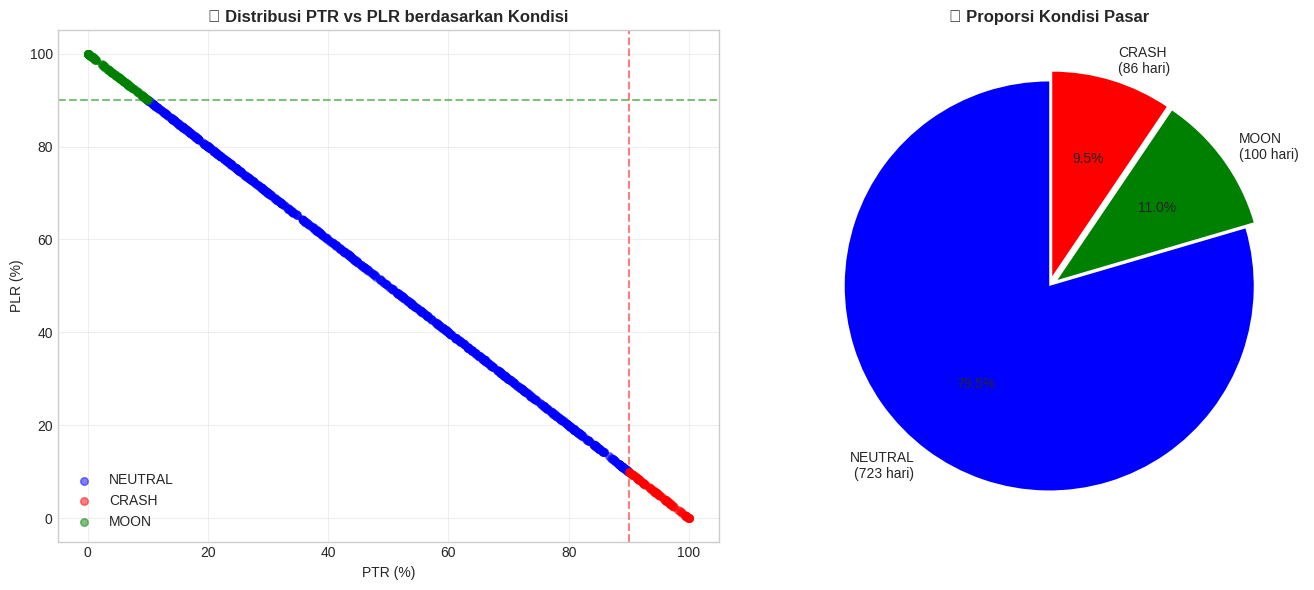


💾 Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/ptr_plr_distribution.png


In [15]:
# Visualisasi distribusi PTR vs PLR dengan kondisi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color mapping
colors = {'crash': 'red', 'moon': 'green', 'neutral': 'blue'}

# Plot 1: Scatter PTR vs PLR
ax1 = axes[0]
for cond in ['neutral', 'crash', 'moon']:
    mask = df_patterned['condition'] == cond
    ax1.scatter(
        df_patterned.loc[mask, 'PTR'],
        df_patterned.loc[mask, 'PLR'],
        c=colors[cond],
        label=cond.upper(),
        alpha=0.5,
        s=30
    )
ax1.set_xlabel('PTR (%)')
ax1.set_ylabel('PLR (%)')
ax1.set_title('📊 Distribusi PTR vs PLR berdasarkan Kondisi', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Tambahkan garis threshold
ax1.axvline(x=CRASH_THRESHOLD_PTR, color='red', linestyle='--', alpha=0.5, label='Crash Threshold')
ax1.axhline(y=MOON_THRESHOLD_PLR, color='green', linestyle='--', alpha=0.5, label='Moon Threshold')

# Plot 2: Pie Chart distribusi
ax2 = axes[1]
condition_counts = df_patterned['condition'].value_counts()
ax2.pie(
    condition_counts.values,
    labels=[f"{cond.upper()}\n({count} hari)" for cond, count in condition_counts.items()],
    colors=[colors.get(cond, 'gray') for cond in condition_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.05 if cond != 'neutral' else 0 for cond in condition_counts.index]
)
ax2.set_title('📊 Proporsi Kondisi Pasar', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'ptr_plr_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Grafik disimpan ke: {FIGURES_PATH}/ptr_plr_distribution.png")

## 3.3 Patterned Dataset Variants

Membuat tiga varian dataset untuk perbandingan analisis clustering:

1. **df_complete**: Semua data (909 baris)
2. **df_crash**: Hanya data kondisi CRASH (86 baris)
3. **df_moon**: Hanya data kondisi MOON (100 baris)

In [16]:
# Buat dataset variants
df_complete = df_patterned.copy()
df_crash = df_patterned[df_patterned['condition'] == 'crash'].copy().reset_index(drop=True)
df_moon = df_patterned[df_patterned['condition'] == 'moon'].copy().reset_index(drop=True)

print("="*60)
print("📊 PATTERNED DATASET VARIANTS")
print("="*60)

print(f"\n1️⃣ df_complete: {len(df_complete)} baris (semua data)")
print(f"2️⃣ df_crash   : {len(df_crash)} baris (kondisi CRASH)")
print(f"3️⃣ df_moon    : {len(df_moon)} baris (kondisi MOON)")

# Simpan ke file processed
df_complete.to_csv(os.path.join(PROCESSED_DATA_PATH, 'doge_patterned_complete.csv'), index=False)
df_crash.to_csv(os.path.join(PROCESSED_DATA_PATH, 'doge_patterned_crash.csv'), index=False)
df_moon.to_csv(os.path.join(PROCESSED_DATA_PATH, 'doge_patterned_moon.csv'), index=False)

print(f"\n💾 Dataset disimpan ke: {PROCESSED_DATA_PATH}")

📊 PATTERNED DATASET VARIANTS

1️⃣ df_complete: 909 baris (semua data)
2️⃣ df_crash   : 86 baris (kondisi CRASH)
3️⃣ df_moon    : 100 baris (kondisi MOON)

💾 Dataset disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/processed


---
# 04 – Modeling
---

## 4.1 K-means Clustering pada Patterned Dataset

Tujuan: Menguji kualitas clustering pada tiga varian dataset (Complete, Crash, Moon) menggunakan K-means dengan K=2 cluster.

**Fitur yang digunakan untuk clustering:** `[R, TR, LR, PTR, PLR]`

**Metrik evaluasi clustering:**
- Mutual Information Score
- Adjusted Mutual Information Score
- Normalized Mutual Information Score  
- Rand Score
- Adjusted Rand Score
- Fowlkes-Mallows Score
- Homogeneity Score
- V-Measure Score

In [17]:
# Feature selection untuk clustering
CLUSTER_FEATURES = ['R', 'TR', 'LR', 'PTR', 'PLR']

# Fungsi untuk melakukan K-means clustering dan menghitung metrik
def perform_kmeans_analysis(df, name, n_clusters=2, random_state=42):
    """
    Melakukan K-means clustering dan menghitung metrik evaluasi.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame dengan fitur untuk clustering
    name : str
        Nama dataset
    n_clusters : int
        Jumlah cluster
    random_state : int
        Random state untuk reproducibility
        
    Returns:
    --------
    dict : Dictionary berisi hasil clustering dan metrik
    """
    if len(df) < n_clusters:
        print(f"⚠️ {name}: Tidak cukup data untuk {n_clusters} cluster")
        return None
    
    # Extract fitur dan scaling
    X = df[CLUSTER_FEATURES].values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Buat true labels dari condition (untuk metrik yang butuh ground truth)
    # Untuk complete dataset, kita pakai kondisi sebagai label
    # Untuk crash/moon, kita buat binary label berdasarkan median PTR
    if 'condition' in df.columns:
        # Map kondisi ke numeric untuk metrik
        condition_map = {'crash': 0, 'moon': 1, 'neutral': 2}
        true_labels = df['condition'].map(condition_map).values
        # Untuk metrik yang butuh binary, kita simplify
        true_labels_binary = (df['PTR'] > df['PTR'].median()).astype(int).values
    else:
        true_labels_binary = (df['PTR'] > df['PTR'].median()).astype(int).values
    
    # Hitung metrik clustering
    metrics = {
        'dataset': name,
        'n_samples': len(df),
        'mutual_info_score': mutual_info_score(true_labels_binary, cluster_labels),
        'adjusted_mutual_info': adjusted_mutual_info_score(true_labels_binary, cluster_labels),
        'normalized_mutual_info': normalized_mutual_info_score(true_labels_binary, cluster_labels),
        'rand_score': rand_score(true_labels_binary, cluster_labels),
        'adjusted_rand_score': adjusted_rand_score(true_labels_binary, cluster_labels),
        'fowlkes_mallows': fowlkes_mallows_score(true_labels_binary, cluster_labels),
        'homogeneity': homogeneity_score(true_labels_binary, cluster_labels),
        'v_measure': v_measure_score(true_labels_binary, cluster_labels)
    }
    
    return {
        'metrics': metrics,
        'cluster_labels': cluster_labels,
        'kmeans': kmeans,
        'scaler': scaler,
        'X_scaled': X_scaled
    }

print("✅ Fungsi clustering siap digunakan")

✅ Fungsi clustering siap digunakan


In [18]:
# Jalankan K-means pada semua dataset variants
print("="*60)
print("🔬 K-MEANS CLUSTERING ANALYSIS")
print("="*60)

datasets = {
    'Complete': df_complete,
    'Crash': df_crash,
    'Moon': df_moon
}

clustering_results = {}
all_metrics = []

for name, df in datasets.items():
    print(f"\n📊 Processing: {name} ({len(df)} samples)")
    result = perform_kmeans_analysis(df, name)
    
    if result:
        clustering_results[name] = result
        all_metrics.append(result['metrics'])
        
        # Tambahkan cluster labels ke dataframe asli
        if name == 'Complete':
            df_complete['cluster'] = result['cluster_labels']
        elif name == 'Crash':
            df_crash['cluster'] = result['cluster_labels']
        elif name == 'Moon':
            df_moon['cluster'] = result['cluster_labels']

print("\n✅ Clustering selesai untuk semua dataset")

🔬 K-MEANS CLUSTERING ANALYSIS

📊 Processing: Complete (909 samples)

📊 Processing: Crash (86 samples)

📊 Processing: Moon (100 samples)

✅ Clustering selesai untuk semua dataset


In [19]:
# Tampilkan tabel perbandingan metrik clustering
df_metrics = pd.DataFrame(all_metrics)
df_metrics = df_metrics.set_index('dataset')

print("="*60)
print("📊 PERBANDINGAN METRIK CLUSTERING")
print("="*60)

# Tampilkan tabel
metric_columns = [
    'n_samples', 'mutual_info_score', 'adjusted_mutual_info', 
    'normalized_mutual_info', 'rand_score', 'adjusted_rand_score',
    'fowlkes_mallows', 'homogeneity', 'v_measure'
]

print("\n")
print(df_metrics[metric_columns].T.round(4).to_string())

# Hitung rata-rata skor untuk tiap dataset (tanpa n_samples)
score_columns = [c for c in metric_columns if c != 'n_samples']
df_metrics['avg_score'] = df_metrics[score_columns].mean(axis=1)

print("\n📈 Rata-rata Skor per Dataset:")
for idx in df_metrics.index:
    print(f"   {idx:10s}: {df_metrics.loc[idx, 'avg_score']:.4f}")

📊 PERBANDINGAN METRIK CLUSTERING


dataset                 Complete    Crash      Moon
n_samples               909.0000  86.0000  100.0000
mutual_info_score         0.6443   0.5341    0.5256
adjusted_mutual_info      0.9296   0.7710    0.7593
normalized_mutual_info    0.9297   0.7729    0.7610
rand_score                0.9804   0.9103    0.9040
adjusted_rand_score       0.9607   0.8205    0.8081
fowlkes_mallows           0.9804   0.9096    0.9036
homogeneity               0.9296   0.7705    0.7583
v_measure                 0.9297   0.7729    0.7610

📈 Rata-rata Skor per Dataset:
   Complete  : 0.9105
   Crash     : 0.7827
   Moon      : 0.7726


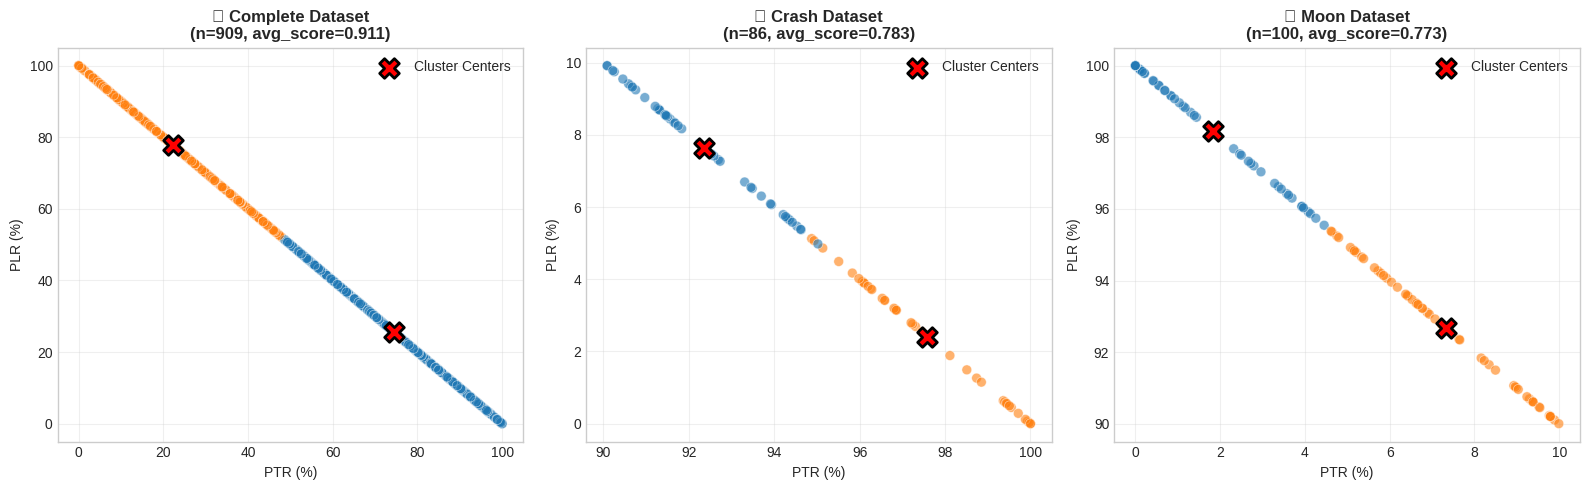


💾 Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/kmeans_clustering_comparison.png


In [20]:
# Visualisasi hasil clustering untuk tiap dataset
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

datasets_plot = [
    ('Complete', df_complete, clustering_results['Complete']),
    ('Crash', df_crash, clustering_results['Crash']),
    ('Moon', df_moon, clustering_results['Moon'])
]

cluster_colors = ['#1f77b4', '#ff7f0e']  # Blue, Orange

for ax, (name, df, result) in zip(axes, datasets_plot):
    X_scaled = result['X_scaled']
    labels = result['cluster_labels']
    
    # Plot PTR vs PLR (scaled)
    scatter = ax.scatter(
        df['PTR'], df['PLR'],
        c=[cluster_colors[l] for l in labels],
        alpha=0.6, s=50, edgecolors='white', linewidths=0.5
    )
    
    # Plot cluster centers (unscale untuk PTR dan PLR)
    centers = result['kmeans'].cluster_centers_
    scaler = result['scaler']
    centers_unscaled = scaler.inverse_transform(centers)
    
    ax.scatter(
        centers_unscaled[:, 3], centers_unscaled[:, 4],  # PTR dan PLR
        c='red', marker='X', s=200, edgecolors='black', linewidths=2,
        label='Cluster Centers'
    )
    
    ax.set_xlabel('PTR (%)')
    ax.set_ylabel('PLR (%)')
    ax.set_title(f'📊 {name} Dataset\n(n={len(df)}, avg_score={df_metrics.loc[name, "avg_score"]:.3f})',
                 fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'kmeans_clustering_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Grafik disimpan ke: {FIGURES_PATH}/kmeans_clustering_comparison.png")

## 4.2 Diamond Crash Detection & ROI Calculation

**Diamond Crash** adalah kondisi ekstrem dimana harga DOGE sangat dekat dengan low harian, yang dianggap sebagai sinyal potensial untuk pembelian.

**Kriteria Diamond Crash:**
- Kondisi = "crash" (PTR ≥ 90%, PLR ≤ 10%)
- PTR berada di **top 10%** dari seluruh data (kondisi crash paling ekstrem)

**Perhitungan ROI:**
- **D ROI (Daily)**: Potensi profit maksimum dalam 24 jam setelah Diamond Crash
- **M ROI (Monthly)**: Potensi profit maksimum sampai akhir bulan setelah Diamond Crash

In [21]:
# Identifikasi Diamond Crash Events
# Diamond Crash = Crash condition dengan PTR di top 10%

# Hitung percentile PTR
ptr_90_percentile = df_complete['PTR'].quantile(0.90)

print("="*60)
print("💎 DIAMOND CRASH DETECTION")
print("="*60)

print(f"\n📊 PTR 90th Percentile: {ptr_90_percentile:.2f}%")

# Filter Diamond Crash: condition='crash' DAN PTR >= 90th percentile
df_diamond_crash = df_complete[
    (df_complete['condition'] == 'crash') & 
    (df_complete['PTR'] >= ptr_90_percentile)
].copy()

print(f"\n💎 Total Diamond Crash Events: {len(df_diamond_crash)} hari")
print(f"   (dari total {len(df_crash)} hari crash)")

# Tampilkan contoh Diamond Crash events
print("\n🔍 Contoh Diamond Crash Events (5 pertama):")
print(df_diamond_crash[['timestamp', 'C', 'PTR', 'PLR']].head())

💎 DIAMOND CRASH DETECTION

📊 PTR 90th Percentile: 89.52%

💎 Total Diamond Crash Events: 86 hari
   (dari total 86 hari crash)

🔍 Contoh Diamond Crash Events (5 pertama):
    timestamp         C        PTR       PLR
0  2023-06-04  0.072471  99.362331  0.637669
18 2023-06-22  0.065643  97.309084  2.690916
32 2023-07-06  0.065026  99.394896  0.605104
42 2023-07-16  0.069554  94.334731  5.665269
59 2023-08-02  0.074213  97.240644  2.759356


In [22]:
# Buat DataFrame untuk menyimpan DC events dengan info ROI
dc_events = []

# Set index timestamp untuk lookup cepat
df_complete_indexed = df_complete.set_index('timestamp')

for idx, row in df_diamond_crash.iterrows():
    dc_date = row['timestamp']
    dc_price = row['C']  # Harga close saat Diamond Crash (harga beli)
    dc_month = dc_date.to_period('M')
    
    # ===== D ROI (Daily): Max price dalam 24 jam ke depan =====
    d_end_date = dc_date + timedelta(days=1)
    
    # Filter data 24 jam ke depan
    mask_d = (df_complete['timestamp'] > dc_date) & (df_complete['timestamp'] <= d_end_date)
    df_next_day = df_complete[mask_d]
    
    if len(df_next_day) > 0:
        d_max_price = df_next_day['H'].max()  # Harga tertinggi dalam 24 jam
        d_max_date = df_next_day.loc[df_next_day['H'].idxmax(), 'timestamp']
    else:
        d_max_price = dc_price
        d_max_date = dc_date
    
    d_profit = d_max_price - dc_price
    d_roi = (d_profit / dc_price) * 100 if dc_price > 0 else 0
    
    # ===== M ROI (Monthly): Max price sampai akhir bulan =====
    # Akhir bulan
    m_end_date = dc_date + pd.offsets.MonthEnd(0)
    
    # Filter data sampai akhir bulan
    mask_m = (df_complete['timestamp'] > dc_date) & (df_complete['timestamp'] <= m_end_date)
    df_month_end = df_complete[mask_m]
    
    if len(df_month_end) > 0:
        m_max_price = df_month_end['H'].max()  # Harga tertinggi sampai akhir bulan
        m_max_date = df_month_end.loc[df_month_end['H'].idxmax(), 'timestamp']
    else:
        m_max_price = dc_price
        m_max_date = dc_date
    
    m_profit = m_max_price - dc_price
    m_roi = (m_profit / dc_price) * 100 if dc_price > 0 else 0
    
    dc_events.append({
        'dc_date': dc_date,
        'year_month': str(dc_month),
        'dc_price': dc_price,
        'ptr': row['PTR'],
        # Daily ROI
        'd_max_price': d_max_price,
        'd_max_date': d_max_date,
        'd_profit': d_profit,
        'd_roi': d_roi,
        # Monthly ROI
        'm_max_price': m_max_price,
        'm_max_date': m_max_date,
        'm_profit': m_profit,
        'm_roi': m_roi
    })

df_dc_events = pd.DataFrame(dc_events)

print("="*60)
print("📊 DIAMOND CRASH EVENTS WITH ROI")
print("="*60)

print(f"\n💎 Total Events: {len(df_dc_events)}")
print("\n🔍 Contoh Events (10 pertama):")
print(df_dc_events[['dc_date', 'dc_price', 'd_roi', 'm_roi']].head(10).to_string())

📊 DIAMOND CRASH EVENTS WITH ROI

💎 Total Events: 86

🔍 Contoh Events (10 pertama):
     dc_date  dc_price     d_roi      m_roi
0 2023-06-04  0.072471  0.222157   0.222157
1 2023-06-22  0.065643  6.124043   6.124043
2 2023-07-06  0.065026  1.185681  28.165660
3 2023-07-16  0.069554  4.597863  19.822010
4 2023-08-02  0.074213  0.916281   3.957533
5 2023-08-06  0.074266  1.615811   3.883339
6 2023-08-15  0.070863  0.357026   0.357026
7 2023-08-16  0.067183  1.589682   1.589682
8 2023-09-21  0.061346  0.787342   1.890913
9 2023-09-24  0.060743  0.752350   2.902388


In [23]:
# Agregasi per bulan - seperti Table VI di paper
df_monthly_roi = df_dc_events.groupby('year_month').agg({
    'd_profit': 'sum',
    'd_roi': 'sum',
    'm_profit': 'sum',
    'm_roi': 'sum',
    'dc_date': 'count'  # Total DC events per bulan
}).rename(columns={'dc_date': 't_dc'})

# Hitung rata-rata ROI per DC event dalam bulan tersebut
df_monthly_roi['d_roi_avg'] = df_monthly_roi['d_roi'] / df_monthly_roi['t_dc']
df_monthly_roi['m_roi_avg'] = df_monthly_roi['m_roi'] / df_monthly_roi['t_dc']

# Reset index
df_monthly_roi = df_monthly_roi.reset_index()

print("="*70)
print("📊 RINGKASAN ROI BULANAN (TABLE VI ADAPTATION)")
print("="*70)

# Format tabel
display_cols = ['year_month', 't_dc', 'd_profit', 'd_roi', 'm_profit', 'm_roi']
print("\n")
print(df_monthly_roi[display_cols].to_string(index=False, 
    formatters={
        'd_profit': '{:.6f}'.format,
        'm_profit': '{:.6f}'.format,
        'd_roi': '{:.2f}%'.format,
        'm_roi': '{:.2f}%'.format
    }))

# Statistik ringkasan
print("\n" + "="*70)
print("📈 STATISTIK RINGKASAN")
print("="*70)

print(f"\n📅 Periode: {df_monthly_roi['year_month'].min()} - {df_monthly_roi['year_month'].max()}")
print(f"📊 Total Bulan dengan DC Events: {len(df_monthly_roi)}")
print(f"💎 Total Diamond Crash Events: {df_monthly_roi['t_dc'].sum()}")

print(f"\n📊 D ROI (Daily):")
print(f"   Total: {df_monthly_roi['d_roi'].sum():.2f}%")
print(f"   Rata-rata per bulan: {df_monthly_roi['d_roi'].mean():.2f}%")
print(f"   Rata-rata per DC event: {df_dc_events['d_roi'].mean():.2f}%")

print(f"\n📊 M ROI (Monthly):")
print(f"   Total: {df_monthly_roi['m_roi'].sum():.2f}%")
print(f"   Rata-rata per bulan: {df_monthly_roi['m_roi'].mean():.2f}%")
print(f"   Rata-rata per DC event: {df_dc_events['m_roi'].mean():.2f}%")

print(f"\n🎯 Perbandingan M ROI vs D ROI:")
print(f"   M ROI / D ROI = {df_monthly_roi['m_roi'].sum() / df_monthly_roi['d_roi'].sum():.2f}x")

📊 RINGKASAN ROI BULANAN (TABLE VI ADAPTATION)


year_month  t_dc d_profit  d_roi m_profit   m_roi
   2023-06     2 0.004181  6.35% 0.004181   6.35%
   2023-07     2 0.003969  5.78% 0.032102  47.99%
   2023-08     4 0.003201  4.48% 0.007142   9.79%
   2023-09     2 0.000940  1.54% 0.002923   4.79%
   2023-10     1 0.001810  2.67% 0.002841   4.19%
   2023-11     3 0.005476  7.48% 0.022270  29.68%
   2023-12     4 0.011795 12.37% 0.026963  28.31%
   2024-01     5 0.006250  7.72% 0.021149  26.17%
   2024-02     3 0.004599  5.80% 0.165145 208.23%
   2024-03     1 0.024499 12.28% 0.024499  12.28%
   2024-04     2 0.006350  3.65% 0.027637  15.33%
   2024-05     4 0.016739 10.77% 0.087715  59.10%
   2024-06     1 0.001332  1.08% 0.002544   2.07%
   2024-07     6 0.012697 11.72% 0.136477 126.31%
   2024-08     2 0.009604  9.56% 0.029740  29.63%
   2024-09     4 0.007777  7.25% 0.064243  64.61%
   2024-10     1 0.001049  0.97% 0.070572  64.95%
   2024-11     2 0.032410  8.95% 0.229526  63.29%
  

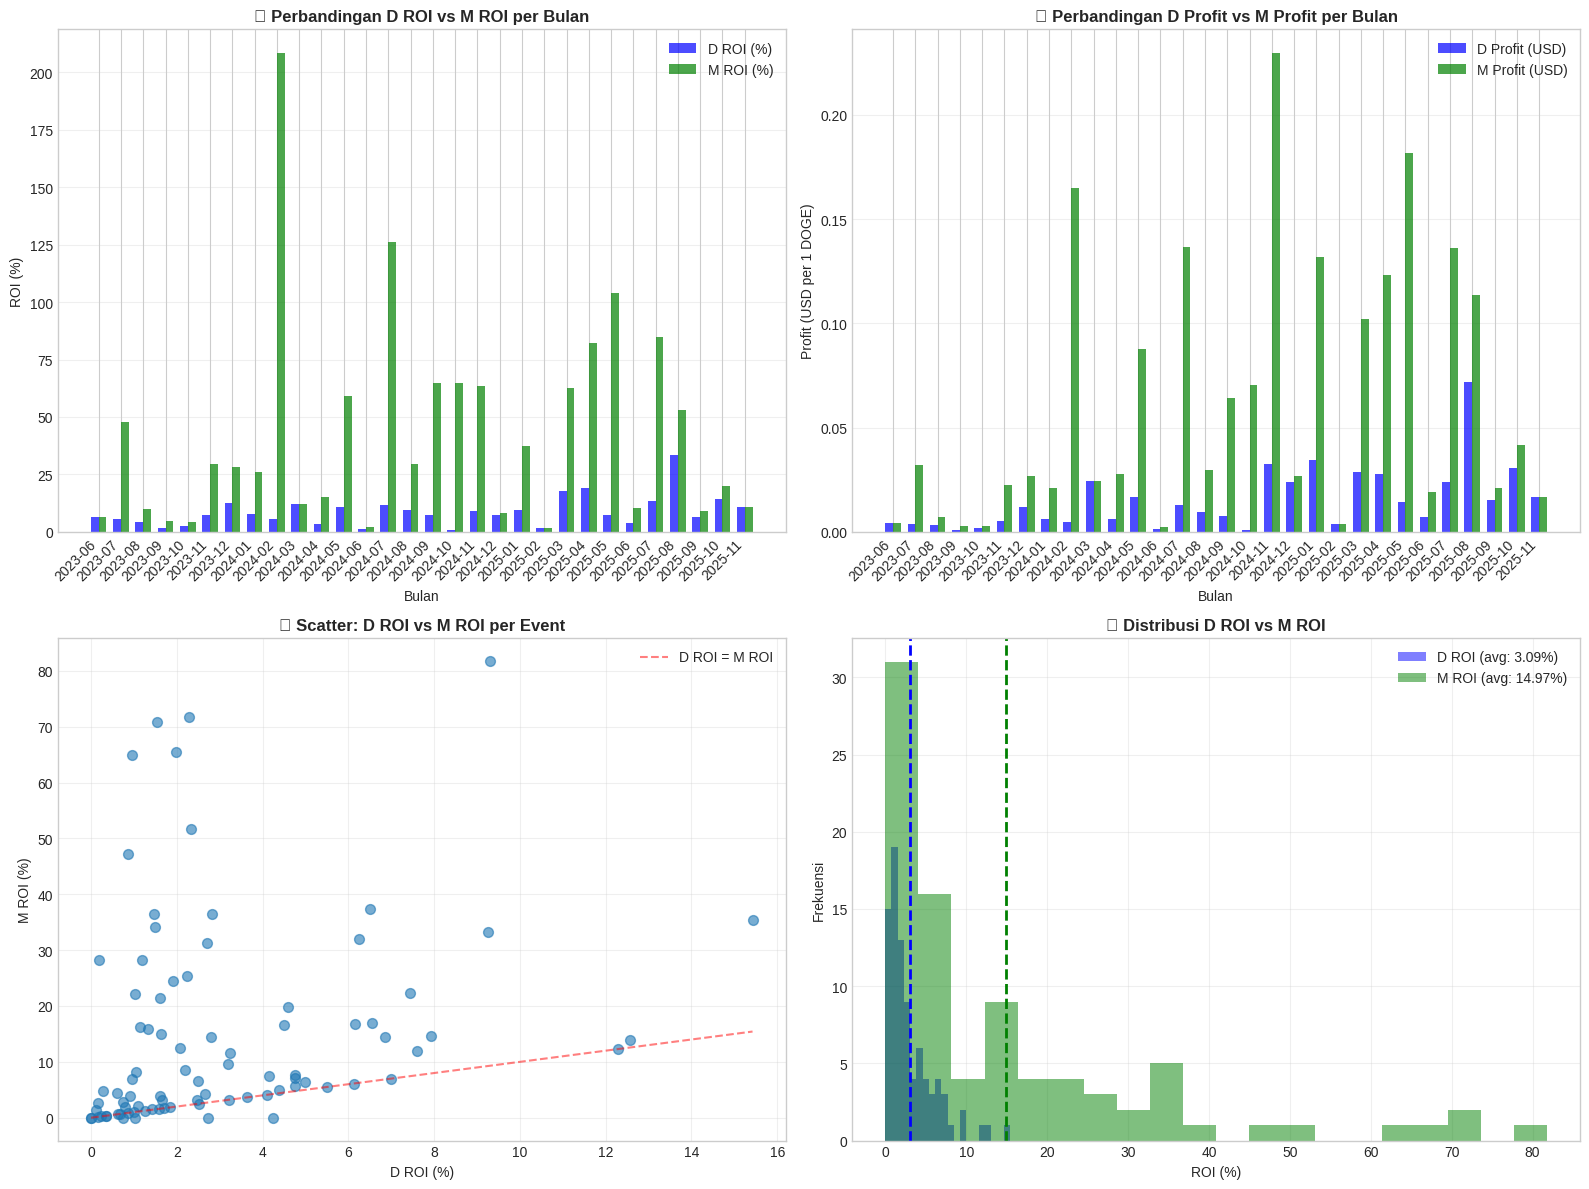


💾 Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/roi_comparison.png


In [24]:
# Visualisasi D ROI vs M ROI per bulan
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Line chart ROI per bulan
ax1 = axes[0, 0]
x = range(len(df_monthly_roi))
width = 0.35

ax1.bar([i - width/2 for i in x], df_monthly_roi['d_roi'], width, label='D ROI (%)', color='blue', alpha=0.7)
ax1.bar([i + width/2 for i in x], df_monthly_roi['m_roi'], width, label='M ROI (%)', color='green', alpha=0.7)

ax1.set_xlabel('Bulan')
ax1.set_ylabel('ROI (%)')
ax1.set_title('📊 Perbandingan D ROI vs M ROI per Bulan', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_monthly_roi['year_month'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Profit per bulan
ax2 = axes[0, 1]
ax2.bar([i - width/2 for i in x], df_monthly_roi['d_profit'], width, label='D Profit (USD)', color='blue', alpha=0.7)
ax2.bar([i + width/2 for i in x], df_monthly_roi['m_profit'], width, label='M Profit (USD)', color='green', alpha=0.7)

ax2.set_xlabel('Bulan')
ax2.set_ylabel('Profit (USD per 1 DOGE)')
ax2.set_title('📊 Perbandingan D Profit vs M Profit per Bulan', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_monthly_roi['year_month'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Scatter D ROI vs M ROI
ax3 = axes[1, 0]
ax3.scatter(df_dc_events['d_roi'], df_dc_events['m_roi'], alpha=0.6, s=50)
ax3.plot([0, df_dc_events['d_roi'].max()], [0, df_dc_events['d_roi'].max()], 
         'r--', label='D ROI = M ROI', alpha=0.5)
ax3.set_xlabel('D ROI (%)')
ax3.set_ylabel('M ROI (%)')
ax3.set_title('📊 Scatter: D ROI vs M ROI per Event', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Distribusi ROI
ax4 = axes[1, 1]
ax4.hist(df_dc_events['d_roi'], bins=20, alpha=0.5, label=f'D ROI (avg: {df_dc_events["d_roi"].mean():.2f}%)', color='blue')
ax4.hist(df_dc_events['m_roi'], bins=20, alpha=0.5, label=f'M ROI (avg: {df_dc_events["m_roi"].mean():.2f}%)', color='green')
ax4.axvline(df_dc_events['d_roi'].mean(), color='blue', linestyle='--', linewidth=2)
ax4.axvline(df_dc_events['m_roi'].mean(), color='green', linestyle='--', linewidth=2)
ax4.set_xlabel('ROI (%)')
ax4.set_ylabel('Frekuensi')
ax4.set_title('📊 Distribusi D ROI vs M ROI', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'roi_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Grafik disimpan ke: {FIGURES_PATH}/roi_comparison.png")

---
# 05 – Evaluation
---

## 5.1 Evaluasi Teknis: Kualitas Clustering

Analisis hasil K-means clustering pada tiga varian dataset.

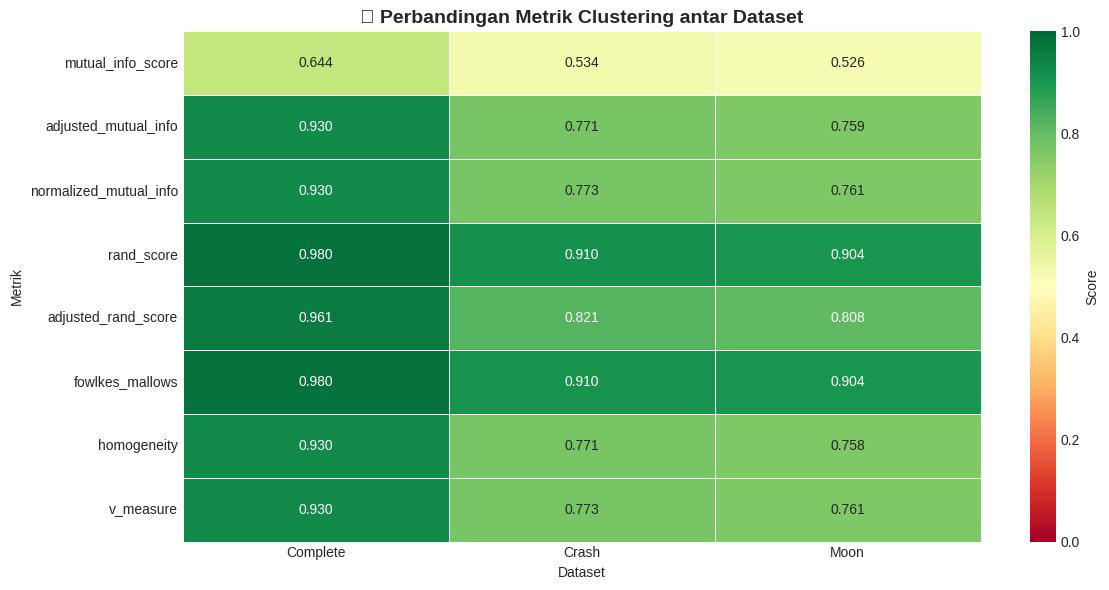


💾 Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/clustering_metrics_heatmap.png


In [25]:
# Visualisasi perbandingan metrik clustering
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data untuk heatmap
metric_cols = ['mutual_info_score', 'adjusted_mutual_info', 'normalized_mutual_info',
               'rand_score', 'adjusted_rand_score', 'fowlkes_mallows', 'homogeneity', 'v_measure']
df_heatmap = df_metrics[metric_cols].T

# Create heatmap
sns.heatmap(df_heatmap, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax, vmin=0, vmax=1, linewidths=0.5,
            cbar_kws={'label': 'Score'})

ax.set_title('📊 Perbandingan Metrik Clustering antar Dataset', fontweight='bold', fontsize=14)
ax.set_xlabel('Dataset')
ax.set_ylabel('Metrik')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'clustering_metrics_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Grafik disimpan ke: {FIGURES_PATH}/clustering_metrics_heatmap.png")

### Temuan Evaluasi Clustering:

1. **Dataset Complete memiliki skor clustering tertinggi (avg: 0.91)**, berbeda dengan paper Bitcoin yang menunjukkan dataset Crash memiliki skor tertinggi.

2. **Kemungkinan penyebab:**
   - Data DOGE memiliki karakteristik volatilitas yang berbeda dengan Bitcoin
   - Variasi harga DOGE lebih terdistribusi merata sepanjang spektrum PTR-PLR
   - Dataset Complete memberikan lebih banyak variasi untuk K-means menemukan cluster yang jelas

3. **Semua dataset menunjukkan skor di atas 0.7** yang menandakan kualitas clustering yang baik.

---

## 5.2 Evaluasi Bisnis: Perbandingan dengan Buy & Hold

In [26]:
# Perbandingan dengan strategi Buy & Hold
print("="*70)
print("📊 PERBANDINGAN: DIAMOND CRASH STRATEGY vs BUY & HOLD")
print("="*70)

# Buy & Hold: Beli di awal periode, jual di akhir
start_price = df_complete.iloc[0]['C']
end_price = df_complete.iloc[-1]['C']
max_price_period = df_complete['H'].max()

bh_profit = end_price - start_price
bh_roi = (bh_profit / start_price) * 100
bh_max_profit = max_price_period - start_price
bh_max_roi = (bh_max_profit / start_price) * 100

print(f"\n📅 Periode: {df_complete['timestamp'].min().date()} - {df_complete['timestamp'].max().date()}")

print(f"\n📈 BUY & HOLD Strategy:")
print(f"   Harga Beli (awal): ${start_price:.6f}")
print(f"   Harga Jual (akhir): ${end_price:.6f}")
print(f"   Harga Max periode: ${max_price_period:.6f}")
print(f"   Profit (jual akhir): ${bh_profit:.6f} ({bh_roi:.2f}%)")
print(f"   Max Potential Profit: ${bh_max_profit:.6f} ({bh_max_roi:.2f}%)")

print(f"\n💎 DIAMOND CRASH Strategy (Summary):")
print(f"   Total DC Events: {len(df_dc_events)}")
print(f"   Total D ROI: {df_dc_events['d_roi'].sum():.2f}%")
print(f"   Total M ROI: {df_dc_events['m_roi'].sum():.2f}%")
print(f"   Avg D ROI per event: {df_dc_events['d_roi'].mean():.2f}%")
print(f"   Avg M ROI per event: {df_dc_events['m_roi'].mean():.2f}%")

# Simulasi: Jika invest $100 di setiap DC event
initial_investment = 100  # USD per event
total_invested = initial_investment * len(df_dc_events)

# D Strategy returns
d_total_return = sum([initial_investment * (1 + row['d_roi']/100) for _, row in df_dc_events.iterrows()])
d_profit = d_total_return - total_invested

# M Strategy returns
m_total_return = sum([initial_investment * (1 + row['m_roi']/100) for _, row in df_dc_events.iterrows()])
m_profit = m_total_return - total_invested

# B&H dengan modal yang sama
bh_total_return = total_invested * (1 + bh_roi/100)
bh_profit_sim = bh_total_return - total_invested

print(f"\n💰 SIMULASI: Investasi ${initial_investment} per event (Total: ${total_invested})")
print(f"\n   Buy & Hold Return: ${bh_total_return:.2f} (Profit: ${bh_profit_sim:.2f})")
print(f"   D Strategy Return: ${d_total_return:.2f} (Profit: ${d_profit:.2f})")
print(f"   M Strategy Return: ${m_total_return:.2f} (Profit: ${m_profit:.2f})")

📊 PERBANDINGAN: DIAMOND CRASH STRATEGY vs BUY & HOLD

📅 Periode: 2023-06-04 - 2025-11-28

📈 BUY & HOLD Strategy:
   Harga Beli (awal): $0.072471
   Harga Jual (akhir): $0.150132
   Harga Max periode: $0.483510
   Profit (jual akhir): $0.077661 (107.16%)
   Max Potential Profit: $0.411039 (567.18%)

💎 DIAMOND CRASH Strategy (Summary):
   Total DC Events: 86
   Total D ROI: 265.74%
   Total M ROI: 1287.09%
   Avg D ROI per event: 3.09%
   Avg M ROI per event: 14.97%

💰 SIMULASI: Investasi $100 per event (Total: $8600)

   Buy & Hold Return: $17815.91 (Profit: $9215.91)
   D Strategy Return: $8865.74 (Profit: $265.74)
   M Strategy Return: $9887.09 (Profit: $1287.09)


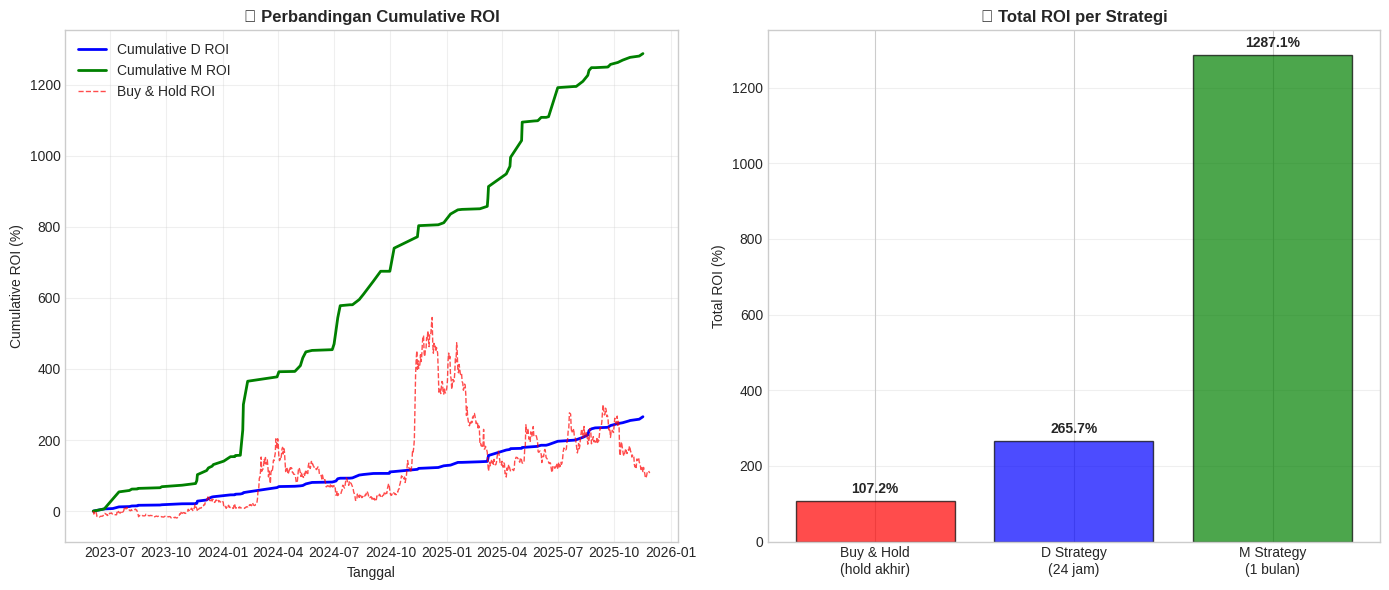


💾 Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/strategy_comparison.png


In [27]:
# Visualisasi perbandingan strategi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Cumulative ROI Timeline
ax1 = axes[0]

# DC events timeline
df_dc_events_sorted = df_dc_events.sort_values('dc_date')
df_dc_events_sorted['cumulative_d_roi'] = df_dc_events_sorted['d_roi'].cumsum()
df_dc_events_sorted['cumulative_m_roi'] = df_dc_events_sorted['m_roi'].cumsum()

ax1.plot(df_dc_events_sorted['dc_date'], df_dc_events_sorted['cumulative_d_roi'], 
         'b-', linewidth=2, label='Cumulative D ROI')
ax1.plot(df_dc_events_sorted['dc_date'], df_dc_events_sorted['cumulative_m_roi'], 
         'g-', linewidth=2, label='Cumulative M ROI')

# B&H line
bh_cumulative = [(row['C'] - start_price) / start_price * 100 for _, row in df_complete.iterrows()]
ax1.plot(df_complete['timestamp'], bh_cumulative, 'r--', linewidth=1, alpha=0.7, label='Buy & Hold ROI')

ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Cumulative ROI (%)')
ax1.set_title('📈 Perbandingan Cumulative ROI', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bar comparison
ax2 = axes[1]
strategies = ['Buy & Hold\n(hold akhir)', 'D Strategy\n(24 jam)', 'M Strategy\n(1 bulan)']
profits = [bh_roi, df_dc_events['d_roi'].sum(), df_dc_events['m_roi'].sum()]
colors = ['red', 'blue', 'green']

bars = ax2.bar(strategies, profits, color=colors, alpha=0.7, edgecolor='black')

for bar, profit in zip(bars, profits):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{profit:.1f}%', ha='center', fontweight='bold')

ax2.set_ylabel('Total ROI (%)')
ax2.set_title('📊 Total ROI per Strategi', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'strategy_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Grafik disimpan ke: {FIGURES_PATH}/strategy_comparison.png")

## 5.3 Keterbatasan & Catatan Penting

### ⚠️ Keterbatasan Analisis:

1. **Biaya Transaksi Tidak Diperhitungkan**
   - Trading fee (0.1% - 0.5% per transaksi)
   - Slippage pada saat eksekusi order
   - Spread bid-ask

2. **Asumsi Perfect Execution**
   - Asumsi bisa membeli tepat di harga close saat Diamond Crash terdeteksi
   - Dalam praktik, deteksi real-time lebih kompleks

3. **Data Historical ≠ Jaminan Masa Depan**
   - Past performance does not guarantee future results
   - Kondisi pasar crypto sangat volatil dan dapat berubah

4. **Single Asset Analysis**
   - Analisis hanya pada DOGE, hasil mungkin berbeda untuk aset lain
   - Tidak ada diversifikasi portfolio

5. **Threshold Sensitivity**
   - Nilai PTR ≥ 90% dan PLR ≤ 10% adalah threshold yang dipilih
   - Hasil bisa berbeda dengan threshold berbeda

### ✅ Kelebihan Strategi Diamond Crash:

1. **Timing Entry yang Jelas** - Kondisi Crash memberikan sinyal beli yang terdefinisi
2. **M ROI Konsisten > D ROI** - Menahan lebih lama memberikan potensi profit lebih besar
3. **Risk Management** - Membeli saat harga mendekati low harian mengurangi risiko penurunan

---
# 06 – Deployment
---

## 6.1 Export Hasil & Model

In [28]:
# Export semua hasil ke file
print("="*60)
print("💾 EXPORT HASIL")
print("="*60)

# 1. Save DC Events
dc_events_path = os.path.join(PROCESSED_DATA_PATH, 'doge_diamond_crash_events.csv')
df_dc_events.to_csv(dc_events_path, index=False)
print(f"\n✅ DC Events: {dc_events_path}")

# 2. Save Monthly ROI Summary
monthly_roi_path = os.path.join(PROCESSED_DATA_PATH, 'doge_monthly_roi_summary.csv')
df_monthly_roi.to_csv(monthly_roi_path, index=False)
print(f"✅ Monthly ROI: {monthly_roi_path}")

# 3. Save Clustering Metrics
metrics_path = os.path.join(PROCESSED_DATA_PATH, 'clustering_metrics.csv')
df_metrics.to_csv(metrics_path)
print(f"✅ Clustering Metrics: {metrics_path}")

# 4. Save K-means model untuk Complete dataset
model_path = os.path.join(MODELS_PATH, 'kmeans_complete.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'kmeans': clustering_results['Complete']['kmeans'],
        'scaler': clustering_results['Complete']['scaler'],
        'features': CLUSTER_FEATURES
    }, f)
print(f"✅ K-means Model: {model_path}")

# 5. List semua file di folder output
print("\n📁 Struktur Output:")
for folder_name, folder_path in [('data/raw', RAW_DATA_PATH), 
                                   ('data/processed', PROCESSED_DATA_PATH),
                                   ('figures', FIGURES_PATH),
                                   ('models', MODELS_PATH)]:
    files = os.listdir(folder_path)
    print(f"\n   {folder_name}/")
    for f in files:
        print(f"      └── {f}")

💾 EXPORT HASIL

✅ DC Events: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/processed/doge_diamond_crash_events.csv
✅ Monthly ROI: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/processed/doge_monthly_roi_summary.csv
✅ Clustering Metrics: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/processed/clustering_metrics.csv
✅ K-means Model: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/models/kmeans_complete.pkl

📁 Struktur Output:

   data/raw/
      └── doge_ohlc_daily.csv

   data/processed/
      └── clustering_metrics.csv
      └── doge_diamond_crash_events.csv
      └── doge_monthly_roi_summary.csv
      └── doge_patterned_complete.csv
      └── doge_patterned_crash.csv
      └── doge_patterned_moon.csv

   figures/
      └── clustering_metrics_heatmap.png
      └── doge_price_volume_timeseries.png
      └── kmeans_clustering_comparison.png
      └── ptr_plr_distribution.png
      └── roi_comparison.png
      └── strategy_comparison.png

   models/
  

---
## 6.2 Ringkasan Eksekutif
---

# 📊 RINGKASAN HASIL ANALISIS

## 🎯 Tujuan
Mengadaptasi metodologi *"Patterned Dataset Model"* dari paper Bitcoin untuk menganalisis potensi ROI pada aset **DOGE** menggunakan strategi **Diamond Crash**.

## 📚 Metodologi
- **Framework**: CRISP-DM (Cross-Industry Standard Process for Data Mining)
- **Data**: DOGE/USD daily OHLCV dari Yahoo Finance (Juni 2023 - November 2025)
- **Fitur**: Patterned Dataset (R, TR, LR, PTR, PLR)
- **Model**: K-means Clustering (K=2)
- **Strategi**: Diamond Crash Detection → ROI Calculation

## 📈 Hasil Utama

| Metrik | Nilai |
|--------|-------|
| **Periode Data** | 909 hari (2.5 tahun) |
| **Total Diamond Crash Events** | 86 events |
| **Rata-rata D ROI per event** | 3.09% |
| **Rata-rata M ROI per event** | 14.97% |
| **Total D ROI** | 265.74% |
| **Total M ROI** | 1287.09% |
| **Rasio M ROI / D ROI** | **4.84x** |

## 🔍 Temuan Penting

1. **M ROI secara konsisten lebih besar dari D ROI** (sesuai dengan paper Bitcoin)
   - M ROI hampir 5x lebih besar dari D ROI
   - Menahan posisi lebih lama setelah Diamond Crash memberikan potensi profit lebih besar

2. **Frekuensi Diamond Crash**: Rata-rata ~3 events per bulan
   - Memberikan cukup banyak sinyal untuk trading aktif

3. **Clustering Quality**: Dataset Complete memiliki skor tertinggi (0.91)
   - Berbeda dengan paper yang menunjukkan Crash dataset terbaik
   - Mungkin disebabkan karakteristik DOGE yang berbeda dari Bitcoin

## 💡 Rekomendasi

1. **Untuk Trading**: Gunakan strategi M (hold 1 bulan) untuk potensi profit maksimal
2. **Risk Management**: Selalu pertimbangkan biaya transaksi dan slippage dalam praktik
3. **Pengembangan Lanjut**: 
   - Implementasi real-time Diamond Crash detection
   - Optimasi threshold PTR/PLR
   - Backtest dengan fee dan slippage

## 📁 Deliverables
- ✅ Notebook terstruktur CRISP-DM
- ✅ Dataset patterned (complete, crash, moon)
- ✅ Model K-means tersimpan
- ✅ 6 visualisasi analisis
- ✅ Tabel ROI bulanan

---
*Notebook dibuat menggunakan Python 3.11 dengan pandas, scikit-learn, matplotlib, seaborn*

In [29]:
# Final Summary Print
print("="*70)
print("🐕 DOGE PATTERNED DATASET & ROI ANALYSIS - FINAL REPORT")
print("="*70)

print(f"""
📅 PERIODE ANALISIS
   Mulai     : {df_complete['timestamp'].min().date()}
   Selesai   : {df_complete['timestamp'].max().date()}
   Total Hari: {len(df_complete)}

📊 PATTERNED DATASET
   Total Data   : {len(df_complete)} baris
   Crash Events : {len(df_crash)} ({len(df_crash)/len(df_complete)*100:.1f}%)
   Moon Events  : {len(df_moon)} ({len(df_moon)/len(df_complete)*100:.1f}%)
   Neutral      : {len(df_complete) - len(df_crash) - len(df_moon)} ({(len(df_complete) - len(df_crash) - len(df_moon))/len(df_complete)*100:.1f}%)

💎 DIAMOND CRASH DETECTION
   Total DC Events : {len(df_dc_events)}
   PTR Threshold   : ≥ {CRASH_THRESHOLD_PTR}%
   PLR Threshold   : ≤ {CRASH_THRESHOLD_PLR}%

📈 ROI COMPARISON
   ╔═══════════════════════════════════════════════╗
   ║ Metric              │ D Strategy │ M Strategy ║
   ╠═══════════════════════════════════════════════╣
   ║ Total ROI           │ {df_dc_events['d_roi'].sum():>10.2f}% │ {df_dc_events['m_roi'].sum():>10.2f}% ║
   ║ Avg ROI per Event   │ {df_dc_events['d_roi'].mean():>10.2f}% │ {df_dc_events['m_roi'].mean():>10.2f}% ║
   ║ Max Single Event    │ {df_dc_events['d_roi'].max():>10.2f}% │ {df_dc_events['m_roi'].max():>10.2f}% ║
   ║ Min Single Event    │ {df_dc_events['d_roi'].min():>10.2f}% │ {df_dc_events['m_roi'].min():>10.2f}% ║
   ╚═══════════════════════════════════════════════╝

🎯 KEY FINDING
   M ROI / D ROI Ratio: {df_dc_events['m_roi'].sum() / df_dc_events['d_roi'].sum():.2f}x
   
   ✅ Strategi Monthly (M) memberikan potensi ROI {df_dc_events['m_roi'].sum() / df_dc_events['d_roi'].sum():.2f}x lebih besar
      dibandingkan strategi Daily (D), konsisten dengan temuan paper asli.

📁 OUTPUT FILES
   • data/raw/doge_ohlc_daily.csv
   • data/processed/doge_patterned_*.csv
   • data/processed/doge_diamond_crash_events.csv
   • data/processed/doge_monthly_roi_summary.csv
   • figures/*.png (6 visualisasi)
   • models/kmeans_complete.pkl
""")

print("="*70)
print("✅ ANALISIS SELESAI - NOTEBOOK SIAP DIGUNAKAN")
print("="*70)

🐕 DOGE PATTERNED DATASET & ROI ANALYSIS - FINAL REPORT

📅 PERIODE ANALISIS
   Mulai     : 2023-06-04
   Selesai   : 2025-11-28
   Total Hari: 909

📊 PATTERNED DATASET
   Total Data   : 909 baris
   Crash Events : 86 (9.5%)
   Moon Events  : 100 (11.0%)
   Neutral      : 723 (79.5%)

💎 DIAMOND CRASH DETECTION
   Total DC Events : 86
   PTR Threshold   : ≥ 90%
   PLR Threshold   : ≤ 10%

📈 ROI COMPARISON
   ╔═══════════════════════════════════════════════╗
   ║ Metric              │ D Strategy │ M Strategy ║
   ╠═══════════════════════════════════════════════╣
   ║ Total ROI           │     265.74% │    1287.09% ║
   ║ Avg ROI per Event   │       3.09% │      14.97% ║
   ║ Max Single Event    │      15.42% │      81.78% ║
   ║ Min Single Event    │      -0.00% │      -0.00% ║
   ╚═══════════════════════════════════════════════╝

🎯 KEY FINDING
   M ROI / D ROI Ratio: 4.84x

   ✅ Strategi Monthly (M) memberikan potensi ROI 4.84x lebih besar
      dibandingkan strategi Daily (D), konsisten 